<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Text_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l
#Restart runtime

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.0+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.1 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.

In [25]:
import collections
import re
from d2l import torch as d2l
import torch

In [2]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
  """Load the time machine dataset into a list of text lines.""" 
  with open(d2l.download('time_machine'), 'r') as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine() 
print(f'# text lines: {len(lines)}') 
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [3]:
lines[:10]

['the time machine by h g wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller for so it will be convenient to speak of him',
 'was expounding a recondite matter to us his grey eyes shone and']

In [4]:
#Tokenization

def tokenize(lines,token='word'):
  if token=='word':
    return [line.split() for line in lines]
  if token=='char':
    return [list(line) for line in lines]
  else:
    print('ERROR: unknown token type: ' + token)

tokens=tokenize(lines)
tokens[:10] #Observe, list of lists where each inner list corresponds to a line

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells'],
 [],
 [],
 [],
 [],
 ['i'],
 [],
 [],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him'],
 ['was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us',
  'his',
  'grey',
  'eyes',
  'shone',
  'and']]

In [5]:
class Vocab:
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None: 
      reserved_tokens = []
    # Sort according to frequencies
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)

    #Build vocab on init
    self.idx_to_token=['<unk>']+reserved_tokens #List
    self.token_to_idx={token:idx for idx,token in enumerate(self.idx_to_token)} #Dict

    for token,freq in self._token_freqs:
      #Don't include tokens with freq<min_freq in the vocab
      if freq<min_freq:
        break
      if token not in self.idx_to_token:
        self.idx_to_token.append(token)
        self.token_to_idx[token]=len(self.idx_to_token)-1

  def __len__(self):
    return len(self.idx_to_token)

  @property
  def unk(self):
    # Index for the unknown token
    return 0
  
  @property
  def token_freqs(self):
    # Counter object 
    return self._token_freqs
  
  def __getitem__(self,tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk) 
    #If tokens is a list 
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    #If indices is a list
    return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
  """Count token frequencies."""
  # Here `tokens` is a 1D list or 2D list
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # Flatten a list of token lists into a 1D list
    tokens = [token for line in tokens for token in line]
  #If its already a 1D list,return  
  return collections.Counter(tokens)


In [6]:
vocab=Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [7]:
#Use getitem function 
print(tokens[0])
vocab[tokens[0]] #Calls vocab.__getitem__(tokens)

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']


[1, 19, 50, 40, 2183, 2184, 400]

In [8]:
def load_corpus_time_machine(max_tokens=-1,level='char'):
  """Return token indices and the vocabulary of the time machine dataset.""" 
  lines = read_time_machine()
  tokens = tokenize(lines, level)
  vocab = Vocab(tokens)
  # Call getitem on a single token and append it to a list
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    corpus = corpus[:max_tokens] #First max_tokens tokens
  return corpus, vocab

corpus, vocab = load_corpus_time_machine() 
len(corpus), len(vocab)

(170580, 28)

In [9]:
corpus, vocab = load_corpus_time_machine(level='word') 
len(corpus), len(vocab)

(32775, 4580)

In [10]:
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

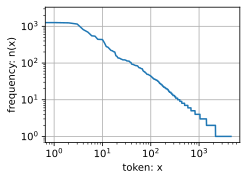

In [11]:
import matplotlib.pyplot as plt
freqs = [freq for token, freq in vocab.token_freqs] 
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

In [12]:
bigram_indices = [pair for pair in zip(corpus[:-1], corpus[1:])] 
bigram_tokens=[(vocab.to_tokens(pair)) for pair in bigram_indices]
bigram_tokens=[tuple(pair) for pair in bigram_tokens]
#bigram tokens is in the format [(bigram_1),(bigram_2)..]
bigram_vocab = Vocab(bigram_tokens) 
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [13]:
trigram_indices = [triple for triple in zip( corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_tokens=[(vocab.to_tokens(triple)) for triple in trigram_indices]
trigram_tokens=[tuple(triple) for triple in trigram_tokens]
#trigram tokens is in the format [(trigram_1),(trigram_2)..]
trigram_vocab = Vocab(trigram_tokens) 
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

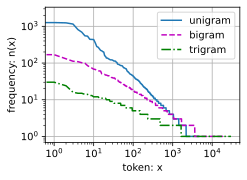

In [14]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs] 
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs] 

d2l.plot([freqs, bigram_freqs, trigram_freqs],
         xlabel='token: x',ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

# Random Sampling 
In random sampling, each example is a subsequence arbitrarily captured on the original long sequence. The subsequences from two adjacent random minibatches during iteration are not necessarily adjacent on the original sequence. For language modeling, the target is to predict the next token based on what tokens we have seen so far, hence the labels are the original sequence, shifted by one token.

In [28]:
import random
def seq_data_iter_random(corpus, batch_size, num_steps):
  """Generate a minibatch of subsequences using random sampling."""
  # Start with a random offset (inclusive of `num_steps - 1`) to partition a # sequence
  corpus = corpus[random.randint(0, num_steps - 1):]
  # Subtract 1 since we need to account for labels
  num_subseqs = (len(corpus) - 1) // num_steps
  # The starting indices for subsequences of length `num_steps` 
  initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
  # In random sampling, the subsequences from two adjacent random
  # minibatches during iteration are not necessarily adjacent on the
  # original sequence
  random.shuffle(initial_indices)

  def data(pos):
  # Return a sequence of length `num_steps` starting from `pos` 
    return corpus[pos: pos + num_steps]
  
  num_batches = num_subseqs // batch_size
  for i in range(0, batch_size * num_batches, batch_size):
    # Here, `initial_indices` contains randomized starting indices for # subsequences
    initial_indices_per_batch = initial_indices[i: i + batch_size]
    X = [data(j) for j in initial_indices_per_batch]
    Y = [data(j + 1) for j in initial_indices_per_batch] 
    yield torch.tensor(X), torch.tensor(Y)

Let us manually generate a sequence from 0 to 34. We assume that the batch size and numbers of time steps are 2 and 5, respectively. This means that we can generate ⌊(35−1)/5⌋ = 6 feature-label subsequence pairs. With a minibatch size of 2, we only get 3 minibatches.

In [29]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [20, 21, 22, 23, 24]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [21, 22, 23, 24, 25]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [15, 16, 17, 18, 19]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [16, 17, 18, 19, 20]])
X:  tensor([[25, 26, 27, 28, 29],
        [10, 11, 12, 13, 14]]) 
Y: tensor([[26, 27, 28, 29, 30],
        [11, 12, 13, 14, 15]])


# Sequential Partitioning 

In addition to random sampling of the original sequence, we can also ensure that the subse- quences from two adjacent minibatches during iteration are adjacent on the original sequence. This strategy preserves the order of split subsequences when iterating over minibatches, hence is called sequential partitioning.

In [30]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
  """Generate a minibatch of subsequences using sequential partitioning.""" 
  # Start with a random offset to partition a sequence
  offset = random.randint(0, num_steps)
  num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
  Xs = torch.tensor(corpus[offset: offset + num_tokens])
  Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
  Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1) 
  num_batches = Xs.shape[1] // num_steps
  for i in range(0, num_steps * num_batches, num_steps):
    X = Xs[:, i: i + num_steps]
    Y = Ys[:, i: i + num_steps] 
    yield X, Y

In [31]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5): 
  print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [32]:
class SeqDataLoader:
  """An iterator to load sequence data."""
  def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
    if use_random_iter:
      self.data_iter_fn = seq_data_iter_random
    else:
      self.data_iter_fn = seq_data_iter_sequential
    
    self.corpus, self.vocab = load_corpus_time_machine(max_tokens) 
    self.batch_size, self.num_steps = batch_size, num_steps

  def __iter__(self):
    return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [33]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
  """Return the iterator and the vocabulary of the time machine dataset."""
  data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
  return data_iter, data_iter.vocab